In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import numpy as np
from sklearn.neighbors import NearestNeighbors

Impotieren der Daten

In [63]:
df = pd.read_excel("Erdbeerfelder.xlsx", sheet_name=0, skiprows=1, usecols="C:D",names=["x","y"])
df = df.astype(float)

**Idee 1** <br>
Die erste Idee, auf die wir kamen, war es, eine Clusteranalyse durchzuführen. Die Punkte mit k-means in zwei Cluster zuteilen und jedes Cluster mit einer Pumpe zu bewässern.

In [64]:
# K-Means-Modell initialisieren und anpassen
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

# Cluster-Zuordnungen für jeden Datenpunkt erhalten
labels = kmeans.labels_

# Cluster-Zuordnungen zum DataFrame hinzufügen
df['Cluster'] = labels


**Visualisierung**

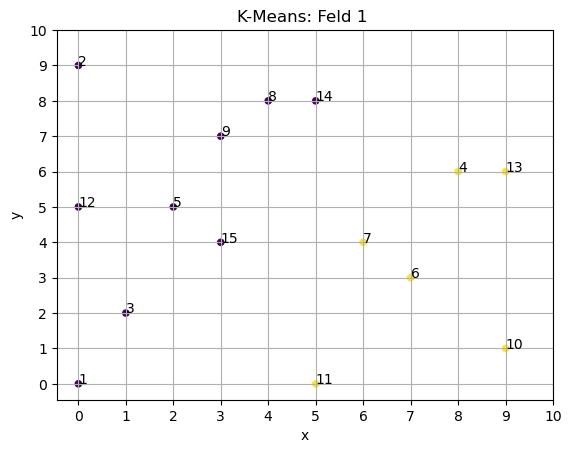

In [65]:
plt.scatter(df["x"], df["y"],s=20,c=labels)
plt.xlabel("x")
plt.ylabel("y")
plt.title("K-Means: Feld 1 ")
plt.grid(True)
for i, txt in enumerate(df.index):
    plt.annotate(txt + 1, (df["x"][i], df["y"][i]))
plt.xticks(range(0, 11, 1))
plt.yticks(range(0, 11, 1))
plt.show()

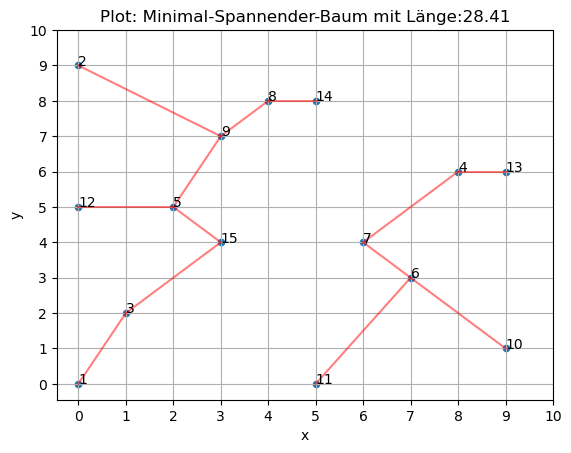

In [66]:
# Erzeuge zwei leere Arrays für die beiden Cluster
Cluster_1 = []
Cluster_2 = []

# Iteriere über den DataFrame und füge Indizes in die entsprechenden Arrays ein
for index, row in df.iterrows():
    cluster_label = row['Cluster']
    if cluster_label == 0:
        Cluster_1.append(index)
    elif cluster_label == 1:
        Cluster_2.append(index)


plot_minimum_spanning_tree(Cluster_1,Cluster_2)

**Ergebnis**<br>
- Gesamtlänge von 28.41
- Eine Pumpe (egal wo) in {1,3,15,5,17,5,9,8,14,2} und eine in {11,6,10,7,4,13}

**Idee2: NearestNeighbors**<br>
- Schaue welcher Punkt am weitesten von allen entfernt ist, also sein nächster Nachbar am weitesten.

In [67]:
# NearestNeighbors-Modell erstellen (2, da jeder Punnkt sich selbst mit zählt, plus 1)
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(df)

# Abstände und Indizes des nächsten Nachbarn finden
distances, indices = nbrs.kneighbors(df)

# Index des Punktes mit dem größten Abstand zum nächsten Nachbarn finden
index_of_furthest_point = np.argmax(distances[:, 1])

# Den Index des am weitesten entfernten Punktes ausgeben
furthest_index = index_of_furthest_point
print("Der am weitesten entfernten Punktes ist:", furthest_index +1)

# Den am weitesten entfernten Punkt im DataFrame ausgeben
furthest_point = df.iloc[furthest_index]
print("Der am weitesten entfernte liegt in:", furthest_point)

Der am weitesten entfernten Punktes ist: 2
Der am weitesten entfernte liegt in: x          0.0
y          9.0
Cluster    0.0
Name: 1, dtype: float64


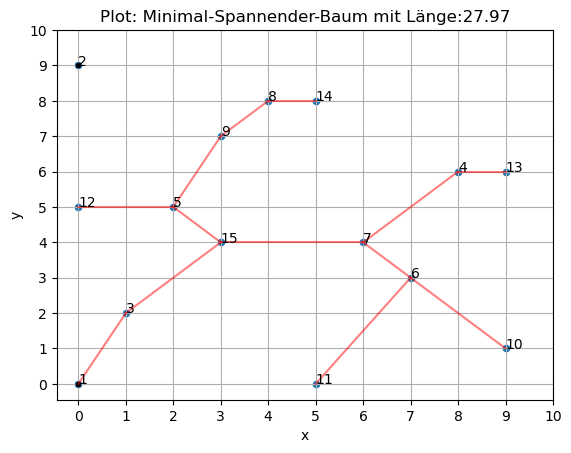

In [68]:
# Array ohne furthest_index
array_without_furthest = df.drop(furthest_index).index

# Array nur mit furthest_index
furthest_index_array = np.array([furthest_index])


# Punkt des am weitesten entfernten Punktes plotten
plt.plot(furthest_point['x'], furthest_point['y'], 'ko',markersize=3)

# Irgendein Punkt schwarz im anderen Baum plotten, der die andere Pumpte darstellen soll
plt.plot(df["x"][array_without_furthest[0]], df["x"][array_without_furthest[0]], 'ko',markersize=3)

# Methode plot_minimum_spanning_tree aufrufen
plot_minimum_spanning_tree(array_without_furthest, furthest_index_array)

# Plot anzeigen
plt.show()

**Ergebnis**<br>
- Gesamtlänge von 27.97
- Eine Pumpe (egal wo) in {1,3,15,5,17,5,9,8,14,11,6,10,7,4,13} und eine in {2}<br>

-> Ergebnis aber nicht für *alle* Fälle minimal.<br>
    -> Learning: Entferne immer die längste Kannte im MST um zwei neue Bäume daraus zuerhalten, die im Summe mnimal sind 

**Idee 3: Entferne längste Kannte im MST**<br>

In [69]:
Graph=dataframe_to_Graph(df)

def student_competition_solver(Graph):
    # Berechnung des minimalen Spannbaums f
    T = nx.minimum_spanning_tree(Graph)

    # Suche die längste Kante
    longest_edge = max(T.edges(data=True), key=lambda x: x[2]['weight'])
    source_node, target_node, edge_attributes = longest_edge

    # Entferne die längste Kante
    T.remove_edge(source_node, target_node)

    # Teile den Graphen in zwei neue Bäume auf
    cut = list(nx.connected_components(T))

    # Knoten des ersten Baums 
    MST1_nodes = list(cut[0])
    # Knoten des zweiten Baums 
    MST2_nodes = list(cut[1])

    return MST1_nodes,MST2_nodes

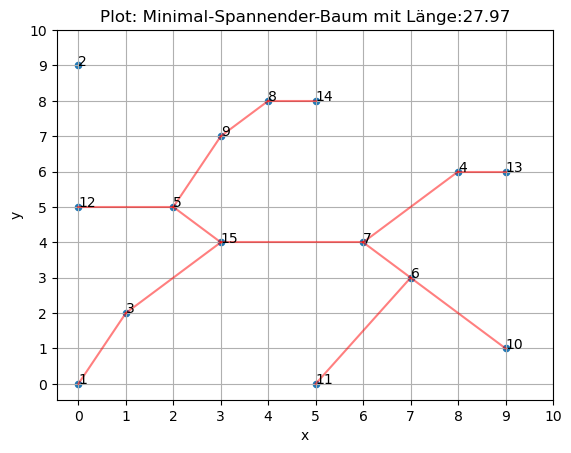

In [70]:
#Visualisierung

plot_minimum_spanning_tree(student_competition_solver(Graph)[0],student_competition_solver(Graph)[1])

**Ergebnis**<br>
- Gesamtlänge von 27.97
- Eine Pumpe (egal wo) in {1,3,15,5,17,5,9,8,14,11,6,10,7,4,13} und eine in {2}<br>
-> ABER: Jetzt Dynamisch für alle Fälle.

In [71]:
def dataframe_to_Graph(df_x):
    # Berechnung der Distanzmatrix
    dist_matrix_x = squareform(pdist(df_x))

    # Erstellung des Netzwerks
    G_x = nx.Graph()

    # Hinzufügen der Knoten
    for i in range(len(df_x)):
        G_x.add_node(i,x=df_x["x"][i], y=df_x["y"][i])

    # Hinzufügen der Kanten mit den Distanzen als Gewicht
    for i in range(len(df_x)):
        for j in range(len(df_x)):
            G_x.add_edge(i, j, weight=dist_matrix_x[i][j])


    return G_x


In [72]:
def plot_minimum_spanning_tree(array_pumpe_1, array_pumpe_2):
    # Erstes DataFrame mit den Indizes aus array_pumpe_1 erstellen
    df1 = df.loc[array_pumpe_1].copy().reset_index(drop=True)
    # Zweites DataFrame mit den Indizes aus array_pumpe_2 erstellen
    df2 = df.loc[array_pumpe_2].copy().reset_index(drop=True)

    Graph_Pumpe1 = dataframe_to_Graph(df1)
    Graph_Pumpe2 = dataframe_to_Graph(df2)

    # Berechnung des minimalen Spannbaums für Pumpe 1
    T_1 = nx.minimum_spanning_tree(Graph_Pumpe1)
    total_length_1 = sum(Graph_Pumpe1[u][v]['weight'] for u, v in T_1.edges())

    # Berechnung des minimalen Spannbaums für Pumpe 2
    T_2 = nx.minimum_spanning_tree(Graph_Pumpe2)
    total_length_2 = sum(Graph_Pumpe2[u][v]['weight'] for u, v in T_2.edges())

    # Scatter-Plot
    plt.scatter(df["x"], df["y"], s=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Plot: Minimal-Spannender-Baum mit Länge:" + str(round(total_length_1 + total_length_2, 2)))
    plt.grid(True)

    # Punkte plotten. Index +1, da wir hier mit 0 anfangen zu zählen
    for i, txt in enumerate(df.index):
        plt.annotate(txt + 1, (df["x"][i], df["y"][i]))

    # Zeichnen der Kanten des minimalen Spannbaums für Pumpe 1
    for (u, v) in T_1.edges():
        x1, y1 = Graph_Pumpe1.nodes[u]["x"], Graph_Pumpe1.nodes[u]["y"]
        x2, y2 = Graph_Pumpe1.nodes[v]["x"], Graph_Pumpe1.nodes[v]["y"]
        plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

    # Zeichnen der Kanten des minimalen Spannbaums für Pumpe 2
    for (u, v) in T_2.edges():
        x1, y1 = Graph_Pumpe2.nodes[u]["x"], Graph_Pumpe2.nodes[u]["y"]
        x2, y2 = Graph_Pumpe2.nodes[v]["x"], Graph_Pumpe2.nodes[v]["y"]
        plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

    plt.xticks(range(0, 11, 1))
    plt.yticks(range(0, 11, 1))
    plt.show()